Assignment 3 - Time-series Data

Names: Niharika Matsa, Krishna Krupa Singamshetty

A weather-forecasting example

In [2]:
import os
import urllib.request
import zipfile

file_url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
file_name = "jena_climate_2009_2016.csv.zip"
csv_file_name = "jena_climate_2009_2016.csv"

# Check if the CSV file already exists, if not, download and extract
if not os.path.exists(csv_file_name):
    # Check if the zip file exists, if not, download it
    if not os.path.exists(file_name):
        print("Downloading file...")
        urllib.request.urlretrieve(file_url, file_name)
        print("Download completed.")

    # Extract the CSV file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        print("Extracting files...")
        zip_ref.extractall()
        print("Extraction completed.")
else:
    print("CSV file already exists. Skipping download and extraction.")


Download completed.
Extracting files...
Extraction completed.


In [ ]:
Examining the Jena weather dataset, comprising 420,451 rows and 15 features

In [3]:
import os
file_name = os.path.join("jena_climate_2009_2016.csv")

with open(file_name) as f:
    data = f.read()

lines = data.split("\n")
head = lines[0].split(",")
lines = lines[1:]
print(head)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


parsing data

In [4]:
import numpy as nump
temp = nump.zeros((len(lines),))
raw_data = nump.zeros((len(lines), len(head) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature in time series dataset

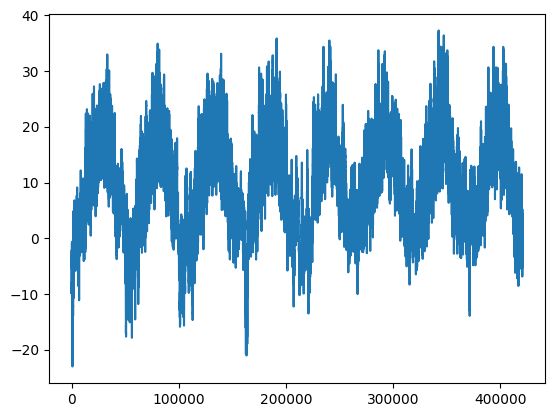

In [5]:
from matplotlib import pyplot as plot
plot.plot(range(len(temp)), temp)

Plotting the first 10 days of temperature in time series data

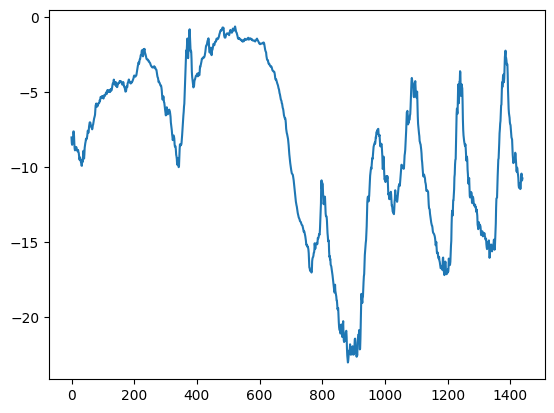

In [6]:
plot.plot(range(1440), temp[:1440])

Splitting the data into training, validation and test samples

In [7]:
training_samples = int(0.5 * len(raw_data))
validation_samples = int(0.25 * len(raw_data))
test_samples = len(raw_data) - training_samples - validation_samples
print("training_samples:", training_samples)
print("validation_samples:", validation_samples)
print("test_samples:", test_samples)


training_samples: 210225
validation_samples: 105112
test_samples: 105114


Pre processing the data

Normalizing the data

In [8]:
Avg = raw_data[:training_samples].mean(axis=0)
raw_data -= Avg
std = raw_data[:training_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as nump
from tensorflow import keras
seq = nump.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=seq[:-3],
    targets=seq[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating separate data collections (training, validation, and testing datasets) for building and evaluating a machine learning model.

In [10]:
sample_rate = 6
seq_len = 120
delay = sample_rate * (seq_len + 24 - 1)
batch_size = 256

training_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples,
    end_index=training_samples + validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples + validation_samples)

Analysing the ouput of training dataset

In [11]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


 Establishing a simple, intuitive baseline approach that does not involve machine learning techniques.

Computing baseline MAE

In [12]:
def evaluate_naive_method(dataset):
    total_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        predictions = samples[:, -1, 1] * std[1] + Avg[1]
        total_err += nump.sum(nump.abs(predictions - targets))
        samples_seen += samples.shape[0]
    return total_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Creating a basic machine learning model

Training the densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs_1 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.Flatten()(inputs_1)
x = layers.Dense(16, activation="relu")(x)
outputs_1 = layers.Dense(1)(x)
model_1 = keras.Model(inputs_1, outputs_1)

callbacks_1 = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model_1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_1 = model_1.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_1)

model_1 = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model_1.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 64ms/step - loss: 15.6482 - mae: 3.0437 - val_loss: 11.1427 - val_mae: 2.6191
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 10.0219 - mae: 2.4886 - val_loss: 10.4098 - val_mae: 2.5245
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 9.0181 - mae: 2.3633 - val_loss: 11.3756 - val_mae: 2.6479
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 8.4389 - mae: 2.2865 - val_loss: 10.8723 - val_mae: 2.6014
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 8.0667 - mae: 2.2338 - val_loss: 11.1232 - val_mae: 2.6282
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 7.7543 - mae: 2.1904 - val_loss: 11.6448 - val_mae: 2.6939
Epoch 7/10
819/819 [==============================] - 52s 64ms/step - loss: 7.5360 - mae: 2.1610 - val_loss: 13.1685 - val_mae: 2.8743
Epoch 8/10
819/819 [==============================] -

Plotting the training and validation MAE

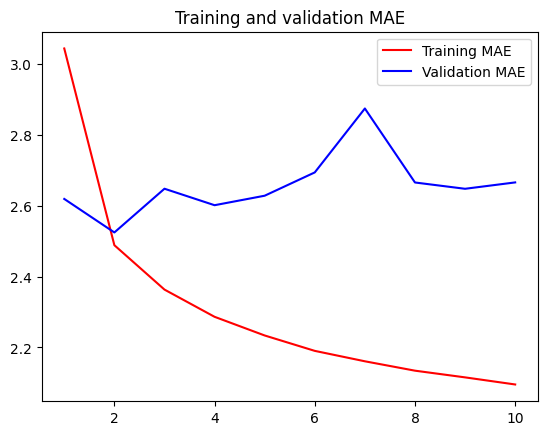

In [14]:
import matplotlib.pyplot as plot
loss_1 = history_1.history["mae"]
validation_loss = history_1.history["val_mae"]
epochs = range(1, len(loss_1) + 1)
plot.figure()
plot.plot(epochs, loss_1, "r", label="Training MAE")
plot.plot(epochs, validation_loss, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Creating a 1D convlutional model

In [15]:
inputs_2 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs_2)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs_2 = layers.Dense(1)(x)
model_2= keras.Model(inputs_2, outputs_2)

callbacks_2 = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model_2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_2 = model_2.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_2)

model_2= keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model_2.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 77s 92ms/step - loss: 21.4137 - mae: 3.5866 - val_loss: 14.5501 - val_mae: 3.0154
Epoch 2/10
819/819 [==============================] - 70s 85ms/step - loss: 14.6550 - mae: 3.0259 - val_loss: 17.4420 - val_mae: 3.3337
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 13.6002 - mae: 2.9159 - val_loss: 16.7490 - val_mae: 3.2549
Epoch 4/10
819/819 [==============================] - 75s 92ms/step - loss: 12.8608 - mae: 2.8351 - val_loss: 13.6945 - val_mae: 2.9295
Epoch 5/10
819/819 [==============================] - 77s 94ms/step - loss: 12.2538 - mae: 2.7702 - val_loss: 15.9094 - val_mae: 3.1518
Epoch 6/10
819/819 [==============================] - 81s 99ms/step - loss: 11.7482 - mae: 2.7155 - val_loss: 13.7902 - val_mae: 2.9212
Epoch 7/10
819/819 [==============================] - 78s 94ms/step - loss: 11.2986 - mae: 2.6623 - val_loss: 14.0027 - val_mae: 2.9471
Epoch 8/10
819/819 [============================

Plotting the training and validation MAE

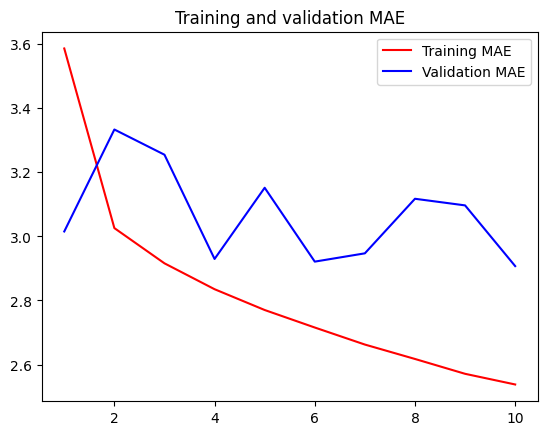

In [16]:
loss_2 = history_2.history["mae"]
val_loss_2 = history_2.history["val_mae"]
epochs = range(1, len(loss_2) + 1)
plot.figure()
plot.plot(epochs, loss_2, "r", label="Training MAE")
plot.plot(epochs, val_loss_2, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Creating a recurrent baseline

Creating a simple LSTM model with Dense 16

In [17]:
inputs_3 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs_3)
outputs_3 = layers.Dense(1)(x)
model_3 = keras.Model(inputs_3, outputs_3)

callbacks_3 = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_3.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_3 = model_3.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_3)

model_3 = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_3.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 97s 115ms/step - loss: 41.4906 - mae: 4.6859 - val_loss: 12.6567 - val_mae: 2.7138
Epoch 2/10
819/819 [==============================] - 112s 136ms/step - loss: 11.0281 - mae: 2.5872 - val_loss: 9.8101 - val_mae: 2.4364
Epoch 3/10
819/819 [==============================] - 93s 113ms/step - loss: 9.9341 - mae: 2.4607 - val_loss: 10.8312 - val_mae: 2.4782
Epoch 4/10
819/819 [==============================] - 93s 113ms/step - loss: 9.5707 - mae: 2.4086 - val_loss: 10.1458 - val_mae: 2.4460
Epoch 5/10
819/819 [==============================] - 114s 139ms/step - loss: 9.2341 - mae: 2.3656 - val_loss: 9.6613 - val_mae: 2.4174
Epoch 6/10
819/819 [==============================] - 92s 112ms/step - loss: 8.9230 - mae: 2.3261 - val_loss: 10.1369 - val_mae: 2.4789
Epoch 7/10
819/819 [==============================] - 113s 138ms/step - loss: 8.6685 - mae: 2.2881 - val_loss: 9.6137 - val_mae: 2.4221
Epoch 8/10
819/819 [==========================

Plotting the training and validation MAE

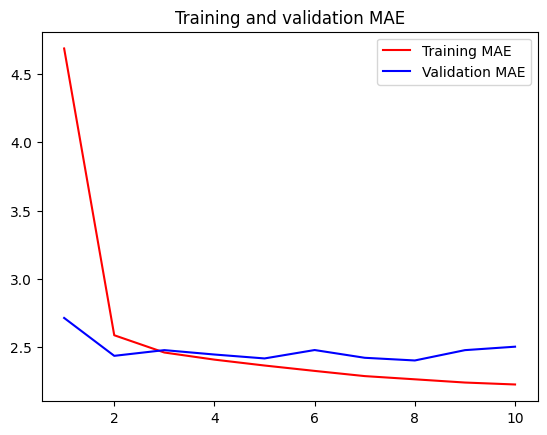

In [18]:
loss_3 = history_3.history["mae"]
val_loss_3 = history_3.history["val_mae"]
epochs = range(1, len(loss_3) + 1)
plot.figure()
plot.plot(epochs, loss_3, "r", label="Training MAE")
plot.plot(epochs, val_loss_3, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Creating a simple LSTM model with Dense 32

In [19]:
inputs_4 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs_4)
outputs_4 = layers.Dense(1)(x)
model_4 = keras.Model(inputs_4, outputs_4)

callbacks_4 = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_4.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_4 = model_4.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_4)

model_4 = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_4.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 138s 166ms/step - loss: 22.7413 - mae: 3.4264 - val_loss: 9.4960 - val_mae: 2.3929
Epoch 2/10
819/819 [==============================] - 138s 169ms/step - loss: 9.4292 - mae: 2.3986 - val_loss: 9.5943 - val_mae: 2.4059
Epoch 3/10
819/819 [==============================] - 138s 167ms/step - loss: 8.5514 - mae: 2.2866 - val_loss: 9.6801 - val_mae: 2.4290
Epoch 4/10
819/819 [==============================] - 138s 168ms/step - loss: 7.8958 - mae: 2.1996 - val_loss: 10.2592 - val_mae: 2.4947
Epoch 5/10
819/819 [==============================] - 137s 167ms/step - loss: 7.4433 - mae: 2.1350 - val_loss: 9.5761 - val_mae: 2.4127
Epoch 6/10
819/819 [==============================] - 140s 170ms/step - loss: 7.0849 - mae: 2.0855 - val_loss: 9.7951 - val_mae: 2.4510
Epoch 7/10
819/819 [==============================] - 139s 169ms/step - loss: 6.7455 - mae: 2.0340 - val_loss: 9.7393 - val_mae: 2.4335
Epoch 8/10
819/819 [==========================

Plotting the training and validation MAE

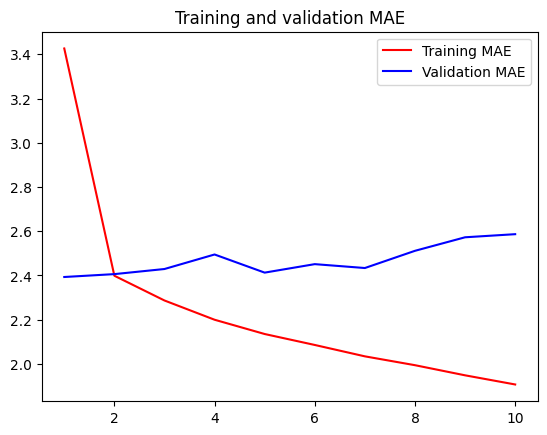

In [20]:
loss_4 = history_4.history["mae"]
val_loss_4 = history_4.history["val_mae"]
epochs = range(1, len(loss_4) + 1)
plot.figure()
plot.plot(epochs, loss_4, "r", label="Training MAE")
plot.plot(epochs, val_loss_4, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Creating a simple LSTM model with Dense 64

In [21]:
inputs_5 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(64)(inputs_5)
outputs_5 = layers.Dense(1)(x)
model_5 = keras.Model(inputs_5, outputs_5)

callbacks_5 = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_5.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_5 = model_5.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_5)

model_5 = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_5.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 244s 296ms/step - loss: 15.2183 - mae: 2.8490 - val_loss: 9.4835 - val_mae: 2.4138
Epoch 2/10
819/819 [==============================] - 280s 341ms/step - loss: 7.4797 - mae: 2.1333 - val_loss: 10.4094 - val_mae: 2.5239
Epoch 3/10
819/819 [==============================] - 280s 341ms/step - loss: 6.0522 - mae: 1.9077 - val_loss: 11.9938 - val_mae: 2.6994
Epoch 4/10
819/819 [==============================] - 278s 339ms/step - loss: 5.0531 - mae: 1.7352 - val_loss: 11.3941 - val_mae: 2.6536
Epoch 5/10
819/819 [==============================] - 281s 343ms/step - loss: 4.3465 - mae: 1.6046 - val_loss: 11.7717 - val_mae: 2.6882
Epoch 6/10
819/819 [==============================] - 278s 339ms/step - loss: 3.8332 - mae: 1.5051 - val_loss: 12.2905 - val_mae: 2.7364
Epoch 7/10
819/819 [==============================] - 244s 297ms/step - loss: 3.4372 - mae: 1.4225 - val_loss: 12.4230 - val_mae: 2.7540
Epoch 8/10
819/819 [=====================

Plotting the training and validation MAE

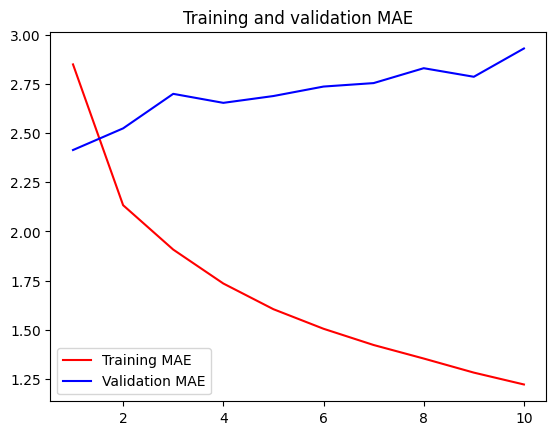

In [22]:
loss_5 = history_5.history["mae"]
val_loss_5 = history_5.history["val_mae"]
epochs = range(1, len(loss_5) + 1)
plot.figure()
plot.plot(epochs, loss_5, "r", label="Training MAE")
plot.plot(epochs, val_loss_5, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Implementing Recurrent neural networks

Implementing Numpy in RNN

In [23]:
import numpy as np
time = 100
input_features = 32
output_features = 64
inputs = np.random.random((time, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

A Recurrent Neural Network (RNN) layer in Keras capable of handling input sequences of varying lengths.

In [24]:
features = 14
inputs_rnn1 = keras.Input(shape=(None, features))
outputs_rnn1 = layers.SimpleRNN(16)(inputs_rnn1)

A Recurrent Neural Network (RNN) layer in Keras that outputs solely the final state from the sequence processing.

In [25]:
features = 14
steps_time = 120
inputs_rnn2 = keras.Input(shape=(steps_time, features))
outputs_rnn2 = layers.SimpleRNN(16, return_sequences=False)(inputs_rnn2)
print(outputs_rnn2.shape)

(None, 16)


A Recurrent Neural Network (RNN) layer in Keras that returns the entire sequence of output values produced while processing the input sequence.

In [26]:
features = 14
steps_time = 120
inputs_rnn3 = keras.Input(shape=(steps_time, features))
outputs_rnn3 = layers.SimpleRNN(16, return_sequences=True)(inputs_rnn3)
print(outputs_rnn3.shape)

(None, 120, 16)


Stacking the RNN layers

In [27]:
inputs_rnn4 = keras.Input(shape=(steps_time, features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs_rnn4)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs_rnn4 = layers.SimpleRNN(16)(x)

Using Advanced RNN layers

 Employing recurrent dropout, a regularization technique, to prevent overfitting in the Recurrent Neural Network model.

 Training and assessing the performance of a combined model consisting of a 1D Convolutional Neural Network and a Dropout-regularized Long Short-Term Memory (LSTM) layer.

In [28]:
inputs_6 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(inputs_6)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs_6 = layers.Dense(1)(x)
model_6 = keras.Model(inputs_6, outputs_6)

callbacks_6 = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_6.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_6 = model_6.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_6)

model_6 = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_6.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 218s 260ms/step - loss: 16.8291 - mae: 3.0910 - val_loss: 9.6841 - val_mae: 2.4300
Epoch 2/10
819/819 [==============================] - 229s 280ms/step - loss: 10.9058 - mae: 2.5667 - val_loss: 10.3499 - val_mae: 2.5085
Epoch 3/10
819/819 [==============================] - 217s 264ms/step - loss: 9.6469 - mae: 2.4037 - val_loss: 10.5099 - val_mae: 2.5202
Epoch 4/10
819/819 [==============================] - 213s 260ms/step - loss: 8.7707 - mae: 2.2828 - val_loss: 10.9737 - val_mae: 2.5969
Epoch 5/10
819/819 [==============================] - 225s 274ms/step - loss: 8.0698 - mae: 2.1843 - val_loss: 10.5493 - val_mae: 2.5380
Epoch 6/10
819/819 [==============================] - 234s 285ms/step - loss: 7.5350 - mae: 2.1086 - val_loss: 11.1469 - val_mae: 2.5891
Epoch 7/10
819/819 [==============================] - 217s 264ms/step - loss: 7.0665 - mae: 2.0385 - val_loss: 11.0724 - val_mae: 2.5993
Epoch 8/10
819/819 [====================

Plotting the training and validation MAE

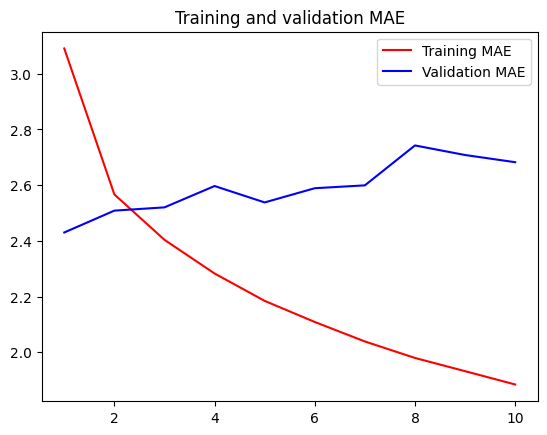

In [29]:
loss_6 = history_6.history["mae"]
val_loss_6 = history_6.history["val_mae"]
epochs = range(1, len(loss_6) + 1)
plot.figure()
plot.plot(epochs, loss_6, "r", label="Training MAE")
plot.plot(epochs, val_loss_6, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

In [30]:
inputs_6 = keras.Input(shape=(seq_len, features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs_6)

Stacking RNN layers

 Training and evaluating a stacked Long Short-Term Memory (LSTM) model that incorporates dropout regularization to mitigate overfitting.

In [31]:
inputs_7 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs_7)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs_7 = layers.Dense(1)(x)
model_7 = keras.Model(inputs_7, outputs_7)

callbacks_7 = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model_7.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_7 = model_7.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks_7)
model_7 = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model_7.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 397s 478ms/step - loss: 27.1407 - mae: 3.8339 - val_loss: 9.8360 - val_mae: 2.4438
Epoch 2/10
819/819 [==============================] - 348s 424ms/step - loss: 13.6784 - mae: 2.8646 - val_loss: 9.3216 - val_mae: 2.3550
Epoch 3/10
819/819 [==============================] - 389s 474ms/step - loss: 12.4374 - mae: 2.7301 - val_loss: 9.6818 - val_mae: 2.3947
Epoch 4/10
819/819 [==============================] - 389s 475ms/step - loss: 11.6745 - mae: 2.6413 - val_loss: 9.7479 - val_mae: 2.4161
Epoch 5/10
819/819 [==============================] - 388s 473ms/step - loss: 10.9198 - mae: 2.5557 - val_loss: 10.0153 - val_mae: 2.4477
Epoch 6/10
819/819 [==============================] - 389s 474ms/step - loss: 10.3295 - mae: 2.4842 - val_loss: 10.5453 - val_mae: 2.5165
Epoch 7/10
819/819 [==============================] - 346s 422ms/step - loss: 9.7661 - mae: 2.4142 - val_loss: 10.9644 - val_mae: 2.5702
Epoch 8/10
819/819 [===================

Plotting the training and validation MAE

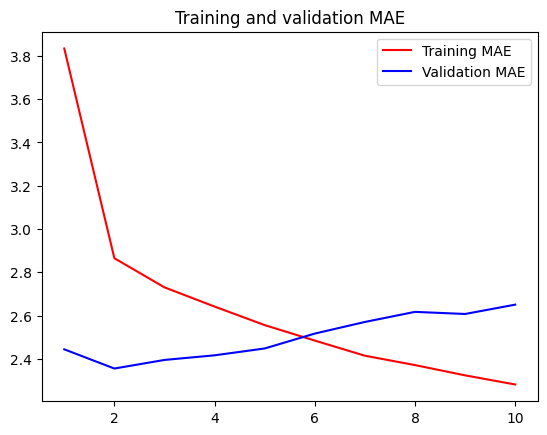

In [32]:
loss_7 = history_7.history["mae"]
val_loss_7 = history_7.history["val_mae"]
epochs = range(1, len(loss_7) + 1)
plot.figure()
plot.plot(epochs, loss_7, "r", label="Training MAE")
plot.plot(epochs, val_loss_7, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()

Using bidirectional RNNs

Training and assessing the performance of a Bidirectional Long Short-Term Memory (Bi-LSTM) model, which processes input sequences in both forward and reverse directions.

In [33]:
inputs_8 = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16,recurrent_dropout=0.25))(inputs_8)
outputs_8 = layers.Dense(1)(x)
model_8 = keras.Model(inputs_8, outputs_8)

model_8.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8 = model_8.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
819/819 [==============================] - 248s 296ms/step - loss: 27.1073 - mae: 3.7463 - val_loss: 9.9416 - val_mae: 2.4380
Epoch 2/10
819/819 [==============================] - 243s 297ms/step - loss: 9.7476 - mae: 2.4391 - val_loss: 9.3633 - val_mae: 2.3622
Epoch 3/10
819/819 [==============================] - 256s 313ms/step - loss: 8.9943 - mae: 2.3391 - val_loss: 9.8688 - val_mae: 2.4216
Epoch 4/10
819/819 [==============================] - 252s 308ms/step - loss: 8.5562 - mae: 2.2786 - val_loss: 9.4362 - val_mae: 2.3708
Epoch 5/10
819/819 [==============================] - 268s 327ms/step - loss: 8.1953 - mae: 2.2300 - val_loss: 9.7617 - val_mae: 2.4148
Epoch 6/10
819/819 [==============================] - 274s 334ms/step - loss: 7.8624 - mae: 2.1862 - val_loss: 9.8647 - val_mae: 2.4158
Epoch 7/10
819/819 [==============================] - 248s 303ms/step - loss: 7.6207 - mae: 2.1529 - val_loss: 10.5416 - val_mae: 2.4914
Epoch 8/10
819/819 [==========================

Plotting the training and validation MAE

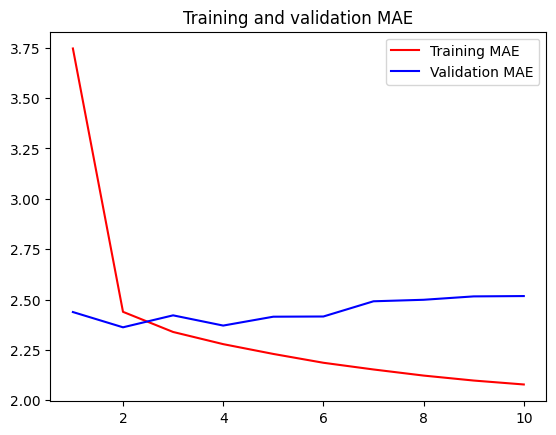

In [34]:
loss_8 = history_8.history["mae"]
val_loss_8 = history_8.history["val_mae"]
epochs = range(1, len(loss_8) + 1)
plot.figure()
plot.plot(epochs, loss_8, "r", label="Training MAE")
plot.plot(epochs, val_loss_8, "b", label="Validation MAE")
plot.title("Training and validation MAE")
plot.legend()
plot.show()